# POGLM on A Synthetic Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from tqdm import trange

from poglm import utils, inference, distributions, model

from importlib import reload
reload(model)
reload(utils)
reload(inference)
reload(distributions)

## Setup the hyperparameters

In [2]:
decay = 0.25
window_size = 5
n_neurons = 5
n_vis_neurons = 3
basis = utils.exp_basis(decay, window_size, window_size)
n_time_bins = 100
n_samples = 60 # same number of sequences for train and test
n_samples_train = 40
n_trials = 10

In [4]:
vari_list = ['F', 'FS', 'FB']
distribution_list = ['Poisson', 'categorical', 'GS-score', 'GS-pathwise', 'exponential', 'Rayleigh', 'half-normal']

In [3]:
n_epochs = 20
print_freq = 1
n_monte_carlo = 5

## Generate a synthetic dataset

In [20]:
torch.manual_seed(0)
gen_model = model.POGLM(n_neurons, n_vis_neurons, basis)
with torch.no_grad():
    gen_model.linear.weight.data = torch.rand((n_neurons, n_neurons)) * 4 - 2
    gen_model.linear.bias.data = torch.rand(n_neurons) * 1 - 0.5
spikes_list, convolved_spikes_list, firing_rates_list = gen_model.sample(n_time_bins, n_samples)

spikes_list_train = spikes_list[:n_samples_train]
convolved_spikes_list_train = convolved_spikes_list[:n_samples_train]
firing_rates_list_train = firing_rates_list[:n_samples_train]
spikes_list_test = spikes_list[n_samples_train:]
convolved_spikes_list_test = convolved_spikes_list[n_samples_train:]
firing_rates_list_test = firing_rates_list[n_samples_train:]

rev_convolved_spikes_list_train = utils.convolve_spikes_with_basis(spikes_list_train, basis, 'backward')

Text(0.5, 0.98, 'Neuron 0, 1, 2 are visible, neuron 3, 4 are hidden')

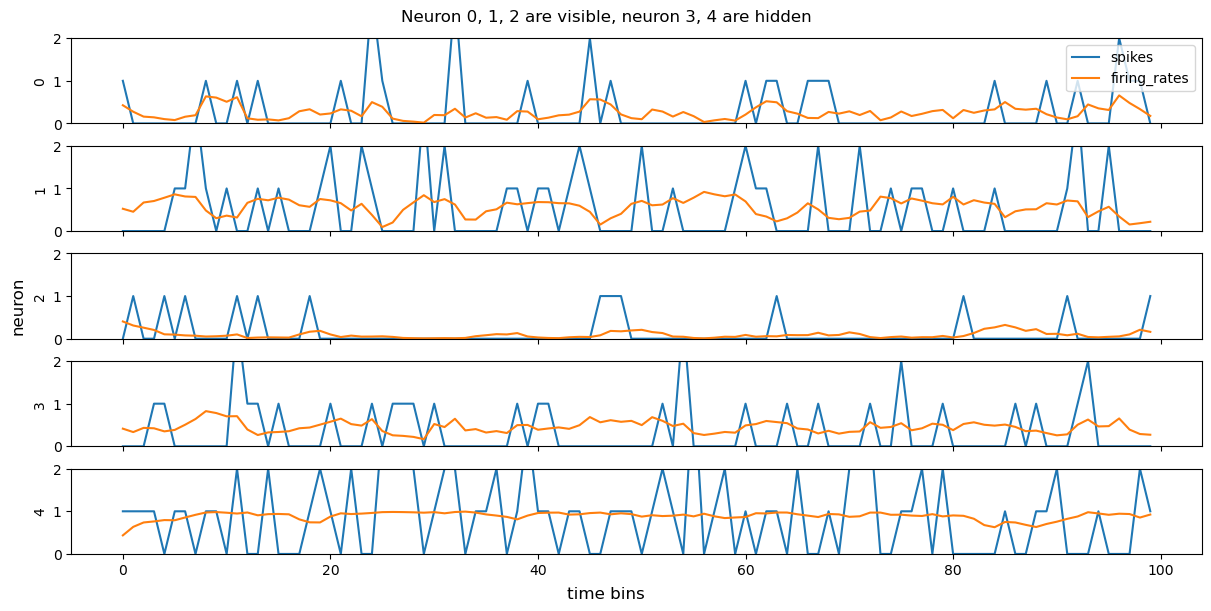

In [21]:
sample = 0
fig, axs = plt.subplots(5, 1, figsize=(12, 6), layout='constrained', sharex=True, sharey=True)
for neuron in range(n_neurons):
    ax = axs[neuron]
    ax.plot(spikes_list_train[sample][:, neuron], label='spikes')
    ax.plot(firing_rates_list_train[sample][:, neuron], label='firing_rates')
    ax.set(ylabel=f'{neuron}', yticks=[0, 1, 2], ylim=(0, 2))
axs[0].legend(loc='upper right')
fig.supxlabel('time bins')
fig.supylabel('neuron')
fig.suptitle('Neuron 0, 1, 2 are visible, neuron 3, 4 are hidden')

## Learn the model with different method combinations

In [22]:
train_dataset = TensorDataset(spikes_list_train[:, :, :n_vis_neurons], convolved_spikes_list_train[:, :, :n_vis_neurons], rev_convolved_spikes_list_train[:, :, :n_vis_neurons])
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=False)

In [61]:
## change this to get the result of the corresponding method combination
vari = 'FB'
distribution = 'Poisson'
# distribution = 'GS-pathwise'
seed = 0

torch.manual_seed(seed)
if vari == 'F':
    vari_model = model.Forward
elif vari == 'FS':
    vari_model = model.ForwardSelf
elif vari == 'FB':
    vari_model = model.ForwardBackward


if distribution == 'Poisson':
    inf_model = model.POGLM(n_neurons, n_vis_neurons, basis, distributions.Poisson())
    vari_model = vari_model(n_neurons, n_vis_neurons, basis, distributions.Poisson())
    grad = 'score'
elif distribution == 'categorical':
    inf_model = model.POGLM(n_neurons, n_vis_neurons, basis, distributions.Categorical(n_categories=5))
    vari_model = vari_model(n_neurons, n_vis_neurons, basis, distributions.Categorical(n_categories=5))
    grad = 'score'
elif distribution == 'GS-score':
    tau = 1.0
    inf_model = model.POGLM(n_neurons, n_vis_neurons, basis, distributions.GumbelSoftmax(n_categories=5, tau=tau))
    vari_model = vari_model(n_neurons, n_vis_neurons, basis, distributions.GumbelSoftmax(n_categories=5, tau=tau))
    grad = 'score'
elif distribution == 'GS-pathwise':
    tau = 0.5
    inf_model = model.POGLM(n_neurons, n_vis_neurons, basis, distributions.GumbelSoftmax(n_categories=5, tau=tau))
    vari_model = vari_model(n_neurons, n_vis_neurons, basis, distributions.GumbelSoftmax(n_categories=5, tau=tau))
    grad = 'pathwise'
elif distribution == 'exponential':
    inf_model = model.POGLM(n_neurons, n_vis_neurons, basis, distributions.Exponential())
    vari_model = vari_model(n_neurons, n_vis_neurons, basis, distributions.Exponential())
    grad = 'pathwise'
elif distribution == 'Rayleigh':
    inf_model = model.POGLM(n_neurons, n_vis_neurons, basis, distributions.Rayleigh())
    vari_model = vari_model(n_neurons, n_vis_neurons, basis, distributions.Rayleigh())
    grad = 'pathwise'
elif distribution == 'half-normal':
    inf_model = model.POGLM(n_neurons, n_vis_neurons, basis, distributions.HalfNormal())
    vari_model = vari_model(n_neurons, n_vis_neurons, basis, distributions.HalfNormal())
    grad = 'pathwise'
with torch.no_grad():
    inf_model.linear.weight.data = torch.zeros((n_neurons, n_neurons))
    inf_model.linear.bias.data = torch.zeros((n_neurons, ))

In [62]:
inf_optimizer = torch.optim.Adam(inf_model.parameters(), lr=0.05)
vari_optimizer = torch.optim.Adam(vari_model.parameters(), lr=0.1)

In [63]:
epoch_loss_list = inference.variational_inference(inf_model, vari_model, inf_optimizer, vari_optimizer, train_dataloader, n_epochs, n_monte_carlo, grad, print_freq, gen_model_state_dict=gen_model.state_dict())

epoch loss weight error bias error
0 222.3311538696289 1.0453276634216309 0.20272178947925568


1 208.24132919311523 0.9821200370788574 0.16817262768745422
2 198.7962646484375 0.9288932085037231 0.2417508065700531
3 195.14871215820312 0.8895832300186157 0.33835485577583313
4 192.8658676147461 0.8525717854499817 0.4198949933052063
5 191.75264739990234 0.8196884393692017 0.4867437481880188
6 192.42113494873047 0.7873677015304565 0.5260122418403625
7 194.05405044555664 0.7544648051261902 0.5366603136062622
8 191.64541244506836 0.7317888736724854 0.559761643409729
9 191.43613052368164 0.7156457304954529 0.6169160604476929
10 191.33709716796875 0.7012226581573486 0.6459866166114807
11 191.85529327392578 0.6862207055091858 0.6520460247993469
12 190.78114318847656 0.6735560894012451 0.6508963704109192
13 189.41384506225586 0.6692085862159729 0.6831844449043274
14 189.99555206298828 0.6782638430595398 0.7075015902519226
15 190.6053695678711 0.6916533708572388 0.7065445184707642
16 189.33515548706055 0.7052342891693115 0.7487902641296387
17 189.28509140014648 0.7119600176811218 0.79597365

In [64]:
true_to_learned = utils.match_hidden_neurons_according_weight(gen_model.state_dict(), inf_model)
inf_model.permute_hidden_neurons(true_to_learned)
vari_model.permute_hidden_neurons(true_to_learned)

## Visualization

Text(0.5, 0.98, 'Leanred weight matrix and bias vector')

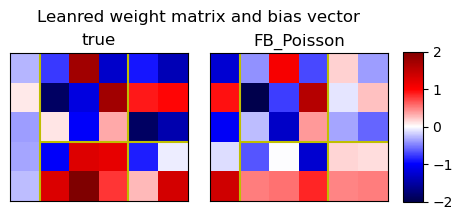

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2), layout='constrained')
utils.visualize_linear(gen_model.state_dict(), n_neurons, n_vis_neurons, axs[0], v=2)
axs[0].set(title='true')
im = utils.visualize_linear(inf_model.state_dict(), n_neurons, n_vis_neurons, axs[1], v=2)
axs[1].set(title=f'{vari}_{distribution}')
fig.colorbar(im, cax=fig.add_axes([1.01, 0.02, 0.05, 0.75]), orientation='vertical')
fig.suptitle('Leanred weight matrix and bias vector')

Text(0.5, 0.98, 'Leanred weight matrix and bias vector')

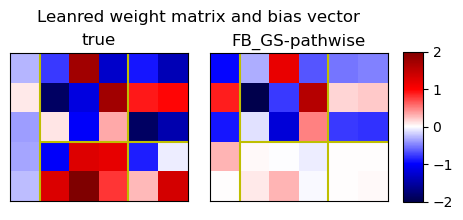

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2), layout='constrained')
utils.visualize_linear(gen_model.state_dict(), n_neurons, n_vis_neurons, axs[0], v=2)
axs[0].set(title='true')
im = utils.visualize_linear(inf_model.state_dict(), n_neurons, n_vis_neurons, axs[1], v=2)
axs[1].set(title=f'{vari}_{distribution}')
fig.colorbar(im, cax=fig.add_axes([1.01, 0.02, 0.05, 0.75]), orientation='vertical')
fig.suptitle('Leanred weight matrix and bias vector')